# Predicting NYC AirBnb Prices in PySpark

This notebook practices ML models in pyspark by attempting to predict the price of AirBnb listings based on features. Data is pulled from [Kaggle](https://www.kaggle.com/dgomonov/new-york-city-airbnb-open-data) 

## Import Relevant Packages and establish Spark Context

In [6]:
from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.sql.functions import when,col
from pyspark.ml.regression import LinearRegression, RandomForestRegressor, GBTRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.feature import VectorAssembler, StringIndexer, OneHotEncoderEstimator
from pyspark.sql.types import DecimalType, IntegerType, DateType, DoubleType
from pyspark.ml import Pipeline

import pandas as pd

sc = SparkContext.getOrCreate()
spark = SparkSession(sc)

## Read in Data

In [2]:
df = spark.read.csv('./AirBnb_NYC_2019.csv',header='true',inferSchema='true')

## Inspect Data

Check available features & types:

In [3]:
df.dtypes

[('id', 'string'),
 ('name', 'string'),
 ('host_id', 'string'),
 ('host_name', 'string'),
 ('neighbourhood_group', 'string'),
 ('neighbourhood', 'string'),
 ('latitude', 'string'),
 ('longitude', 'string'),
 ('room_type', 'string'),
 ('price', 'string'),
 ('minimum_nights', 'string'),
 ('number_of_reviews', 'string'),
 ('last_review', 'string'),
 ('reviews_per_month', 'string'),
 ('calculated_host_listings_count', 'string'),
 ('availability_365', 'int')]

A good amount of these are string, we'll need to convert these to numeric types to run our analysis:

In [48]:
df = df.withColumn("latitude",df["latitude"].cast(DoubleType()))
df = df.withColumn("longitude",df["longitude"].cast(DoubleType()))
df = df.withColumn("price",df["price"].cast(IntegerType()))
df = df.withColumn("minimum_nights",df["minimum_nights"].cast(IntegerType()))
df = df.withColumn("number_of_reviews",df["number_of_reviews"].cast(IntegerType()))
df = df.withColumn("calculated_host_listings_count",df["calculated_host_listings_count"].cast(IntegerType()))
df = df.withColumn("last_review",df["last_review"].cast(DateType()))
df = df.withColumn("reviews_per_month",df["reviews_per_month"].cast(DoubleType()))
df = df.withColumn("availability_365",df["availability_365"].cast(IntegerType()))

Quick Overview of pairplots:

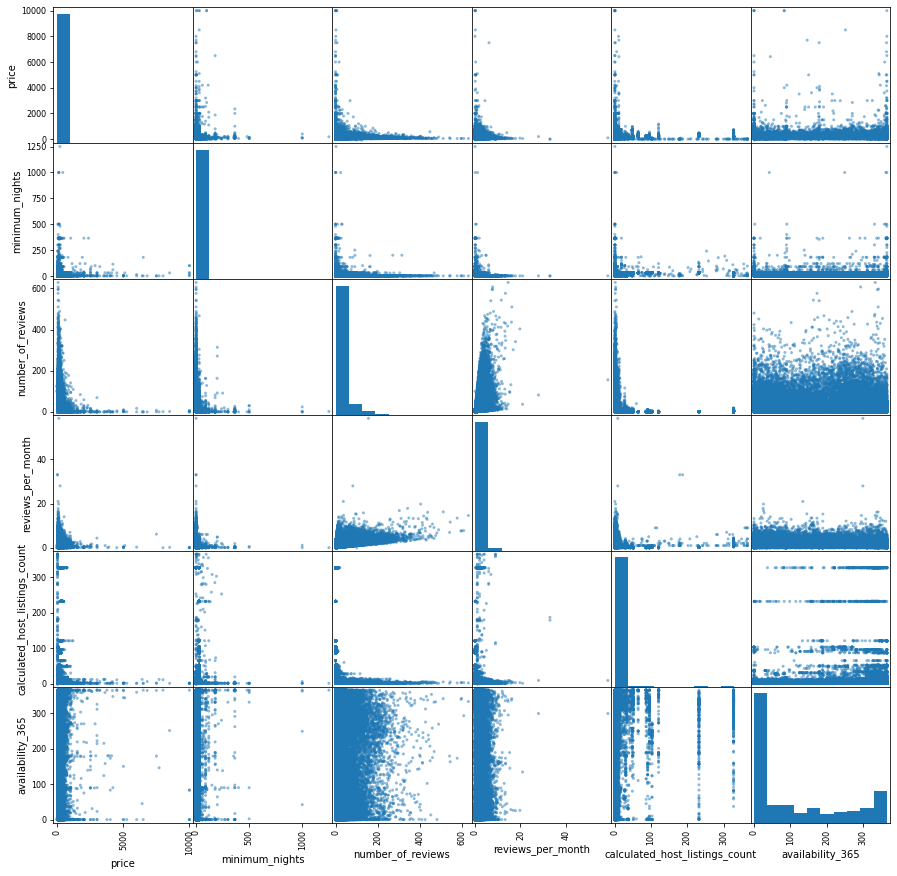

In [7]:
numeric = [col[0] for col in df.dtypes if col[1] in ['int','float','double','decimal(10,0)']]
data_mat = df.select(numeric).toPandas()
data_mat.reviews_per_month = data_mat.reviews_per_month.astype(float)
pd.plotting.scatter_matrix(data_mat, figsize=(15,15));

Data is highly skewed due to major outliers. Further seen in the max values & std dev:

In [50]:
df.select('price','number_of_reviews','minimum_nights','longitude').describe().show()

+-------+------------------+------------------+-----------------+---------+
|summary|             price| number_of_reviews|   minimum_nights|longitude|
+-------+------------------+------------------+-----------------+---------+
|  count|             38678|             38678|            38678|    38678|
|   mean|127.12459279176792|24.310202182119035|5.158772428770877|    -74.0|
| stddev| 75.38627310145063| 30.74882509460958|7.730460002805559|      0.0|
|    min|                 0|                 1|                1|    -74.0|
|    max|               300|               100|               30|    -74.0|
+-------+------------------+------------------+-----------------+---------+



Handeling Outliers by capping at 95th - 99th quantiles

In [8]:
df = df.withColumn("price", when(col("price")>300,300).otherwise(col("price")))
df = df.filter(df['price']>=0)
df = df.withColumn("minimum_nights", when(col("minimum_nights")>30,30).otherwise(col("minimum_nights")))
df = df.withColumn('calculated_host_listings_count', when(col('calculated_host_listings_count')>10,
                                                           10).otherwise(col('calculated_host_listings_count')))
df = df.Handling these outliers:withColumn("reviews_per_month",when(col('reviews_per_month')>10,10).otherwise(col('reviews_per_month')))
df = df.withColumn('number_of_reviews', when(col('number_of_reviews')>100,100).otherwise(col('number_of_reviews')))

Much better metrics

In [16]:
df.select('price','number_of_reviews','minimum_nights','calculated_host_listings_count').describe().show()

+-------+------------------+------------------+-----------------+------------------------------+
|summary|             price| number_of_reviews|   minimum_nights|calculated_host_listings_count|
+-------+------------------+------------------+-----------------+------------------------------+
|  count|             48885|             48729|            48885|                         48885|
|   mean|130.40875524189426|19.311908719653594|5.985803416180833|            2.2207016467218983|
| stddev| 78.67245107919103| 29.11761284864918|8.706191426740308|            2.4893597723534038|
|    min|                 0|                 0|                0|                             0|
|    max|               300|               100|               30|                            10|
+-------+------------------+------------------+-----------------+------------------------------+



## Prepare for modeling

Create Dummy variables for categorical:

In [17]:
#creates indexes for each string
indexers = [StringIndexer(inputCol=col, 
                          outputCol=col+'_index',
                         handleInvalid='keep').fit(df) for col in ['neighbourhood_group',
                                                                      'neighbourhood',
                                                                      'room_type']]
pipe = Pipeline(stages=indexers)
df = pipe.fit(df).transform(df)

#creates columns with 0 or 1 for each index
encoder = OneHotEncoderEstimator(inputCols=['neighbourhood_group_index','neighbourhood_index',
                                             'room_type_index'],
                                 outputCols=['neighbourhood_group_dummy','neighbourhood_dummy',
                                             'room_type_dummy'],
                                dropLast=True)
df = encoder.fit(df).transform(df)

df = df.na.drop()

Vectorize features to allow for spark ml to read them:

In [26]:
target = 'price'
features = df.drop('id',
                     'name',
                     'host_id',
                     'host_name',
                     'neighbourhood_group_index',
                     'neighbourhood_index',
                     'room_type_index',
                     'neighbourhood_group',
                     'neighbourhood',
                     'room_type',
                  'price',
                  'last_review').columns

vector = VectorAssembler(inputCols= features,
                         outputCol='features')

vectorized_df = vector.transform(df)
vectorized_df = vectorized_df.select(['features','price'])
vectorized_df.head(1)

[Row(features=SparseVector(529, {0: 41.0, 1: -74.0, 2: 1.0, 3: 9.0, 4: 0.21, 5: 6.0, 6: 365.0, 8: 1.0, 127: 1.0, 453: 1.0}), price=149)]

Train/test Split:

In [32]:
train_data, test_data = vectorized_df.randomSplit([.75,.25])

Linear Regression:

In [33]:
lin_reg = LinearRegression(featuresCol='features', labelCol='price')

lr = lin_reg.fit(train_data)

pred = lr.transform(test_data)

lr_eval = RegressionEvaluator(labelCol='price')
rmse = lr_eval.evaluate(pred)

print("Linear Regression")
print("R^2 Value: \t",lr.summary.r2)
print("Train RMSE Value: \t",lr.summary.rootMeanSquaredError)
print("Test RMSE Value: \t", rmse)

Linear Regression
R^2 Value: 	 0.5403433243241518
Train RMSE Value: 	 51.125453827560364
Test RMSE Value: 	 50.587790063440046


Random Forrest:

In [39]:
rf_reg = RandomForestRegressor(featuresCol='features', labelCol='price')

rf = rf_reg.fit(train_data)

train_pred = rf.transform(train_data)
test_pred = rf.transform(test_data)

rf_eval = RegressionEvaluator(labelCol='price')
rmse_train = rf_eval.evaluate(train_pred)
rmse_test = rf_eval.evaluate(test_pred)

print("Random Forrest Regression")
print("Train RMSE Value: \t",rmse_train)
print("Test RMSE Value: \t",rmse_test)

Random Forrest Regression
Train RMSE Value: 	 53.782628600784975
Test RMSE Value: 	 53.03799650426788


Gradient Boosting:

In [38]:
gbt_reg = GBTRegressor(featuresCol='features', labelCol='price')

gbt = gbt_reg.fit(train_data)

train_pred = gbt.transform(train_data)
test_pred = gbt.transform(test_data)

gbt_eval = RegressionEvaluator(labelCol='price')
rmse_train = gbt_eval.evaluate(train_pred)
rmse_test = gbt_eval.evaluate(test_pred)

print("Gradient Boost Regression")
print("Train RMSE Value: \t",rmse_train)
print("Test RMSE Value: \t",rmse_test)

Gradient Boost Regression
Train RMSE Value: 	 50.24125036751643
Test RMSE Value: 	 50.293358676420034


Checking to see if Linear Regression Statsmodels returns similar results

In [68]:
from statsmodels.formula.api import ols
import statsmodels as sm

def reg_formula(outcome,features):
    """
    Takes in outcome and features and returns linear regression formula in r
    
    Outcome: String of title of outcome column
    features: list of strings of feature columns
    """
    
    pred_sum = '+'.join(features)
    return outcome + '~' + pred_sum

def sm_reg(outcome,features,dataset):
    """
    Takes in outcome, features and data set and returns linear regression summary table using statsmodels
    
    outcome: String of title of outcome column
    features: list of strings of feature columns
    dataset: pandas dataframe containing columns that include outcome and features as titles to train model on
    """
    formula = reg_formula(outcome,dataset[features])
    regression = ols(formula=formula,data=dataset).fit()
    return regression.summary()

In [104]:
dfpd =  pd.read_csv('./AirBnb_NYC_2019.csv')
dfpd.drop(columns=['id','name','host_name','host_id','last_review'], inplace=True)
dfpd.reviews_per_month = dfpd.reviews_per_month.fillna(0)
dfpd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48895 entries, 0 to 48894
Data columns (total 11 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   neighbourhood_group             48895 non-null  object 
 1   neighbourhood                   48895 non-null  object 
 2   latitude                        48895 non-null  float64
 3   longitude                       48895 non-null  float64
 4   room_type                       48895 non-null  object 
 5   price                           48895 non-null  int64  
 6   minimum_nights                  48895 non-null  int64  
 7   number_of_reviews               48895 non-null  int64  
 8   reviews_per_month               48895 non-null  float64
 9   calculated_host_listings_count  48895 non-null  int64  
 10  availability_365                48895 non-null  int64  
dtypes: float64(3), int64(5), object(3)
memory usage: 4.1+ MB


In [105]:
dfpd = pd.get_dummies(dfpd, columns=['neighbourhood_group','neighbourhood','room_type'],drop_first=True)

In [106]:
dfpd.columns = [col.replace(" ","_").replace("'","").replace("/","").replace(".","").replace("-","").replace(",","") for col in dfpd.columns]
l = list(dfpd.columns)
l.remove('price')

In [107]:
import numpy as np
dfpd.price = np.where(dfpd.price > 300,300,dfpd.price)
dfpd.price = np.where(dfpd.price < 0,0,dfpd.price)
dfpd.minimum_nights = np.where(dfpd.minimum_nights>30,30,dfpd.minimum_nights)
dfpd.calculated_host_listings_count = np.where(dfpd.calculated_host_listings_count >10, 10, dfpd.calculated_host_listings_count)
dfpd.reviews_per_month = np.where(dfpd.reviews_per_month >10,10,dfpd.reviews_per_month)
dfpd.number_of_reviews = np.where(dfpd.number_of_reviews >100,100,dfpd.number_of_reviews)

In [108]:
sm_reg('price',l,dfpd)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.539
Model:                            OLS   Adj. R-squared:                  0.537
Method:                 Least Squares   F-statistic:                     248.8
Date:                Thu, 25 Feb 2021   Prob (F-statistic):               0.00
Time:                        20:06:46   Log-Likelihood:            -2.6374e+05
No. Observations:               48895   AIC:                         5.279e+05
Df Residuals:                   48665   BIC:                         5.300e+05
Df Model:                         229                                         
Covariance Type:            nonrobust                                         
===========================================================================================================
                                              coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------
Intercept                                -3.43e+04   3122.981    -10.984      0.000   -4.04e+04   -2.82e+04
latitude                                  -56.7710     43.849     -1.295      0.195    -142.715      29.173
longitude                                -497.5670     33.446    -14.877      0.000    -563.121    -432.013
minimum_nights                             -1.2349      0.033    -37.153      0.000      -1.300      -1.170
number_of_reviews                          -0.1824      0.011    -16.655      0.000      -0.204      -0.161
reviews_per_month                          -1.0388      0.211     -4.932      0.000      -1.452      -0.626
calculated_host_listings_count              0.0860      0.124      0.694      0.488      -0.157       0.329
availability_365                            0.1065      0.002     49.431      0.000       0.102       0.111
neighbourhood_group_Brooklyn              -39.3963     12.581     -3.131      0.002     -64.056     -14.737
neighbourhood_group_Manhattan               3.8123     10.019      0.381      0.704     -15.825      23.450
neighbourhood_group_Queens                 25.9750     10.932      2.376      0.018       4.547      47.403
neighbourhood_group_Staten_Island        -139.0277     16.965     -8.195      0.000    -172.279    -105.777
neighbourhood_Arden_Heights               -74.9332     26.607     -2.816      0.005    -127.084     -22.782
neighbourhood_Arrochar                     10.8712     12.322      0.882      0.378     -13.279      35.022
neighbourhood_Arverne                      28.3793      8.045      3.527      0.000      12.610      44.148
neighbourhood_Astoria                     -43.2224      4.899     -8.824      0.000     -52.824     -33.621
neighbourhood_Bath_Beach                  -58.9494     13.018     -4.528      0.000     -84.465     -33.434
neighbourhood_Battery_Park_City            -3.9682      6.697     -0.593      0.553     -17.095       9.158
neighbourhood_Bay_Ridge                   -44.3764      5.117     -8.672      0.000     -54.406     -34.346
neighbourhood_Bay_Terrace                  52.9199     21.725      2.436      0.015      10.339      95.501
neighbourhood_Bay_Terrace_Staten_Island   -22.2416     37.214     -0.598      0.550     -95.182      50.699
neighbourhood_Baychester                   -3.5192     21.804     -0.161      0.872     -46.255      39.217
neighbourhood_Bayside                      29.8141      9.036      3.300      0.001      12.104      47.524
neighbourhood_Bayswater                    12.4563     13.722      0.908      0.364     -14.440      39.352
neighbourhood_BedfordStuyvesant             6.5870      2.112      3.118      0.002       2.447      10.727
neighbourhood_Belle_Harbor                 16.1412     19.4